In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing

# Load newest Google stock data from Yahoo Finance

In [2]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('GOOG','yahoo',start,end)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,100.000168,104.060182,95.960165,100.340176,44871300,50.119968
2004-08-20,101.010175,109.080187,100.500174,108.310183,22942800,54.100990
2004-08-23,110.750191,113.480193,109.050183,109.400185,18342800,54.645447
2004-08-24,111.240189,111.600192,103.570177,104.870176,15319700,52.382705
2004-08-25,104.960181,108.000187,103.880180,106.000184,9232100,52.947145


# Normalise and Prepozess the data like a boss^12

In [3]:
#normalise data
data_n = stock_data_preprocessing.normalise_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
2004-08-19,0.731812,3.0,0.543621,1.000000,0.996611,1.037074,0.956348,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-20,0.731813,4.0,0.277955,1.079430,1.006677,1.087104,1.001595,-0.722045,0.079430,0.006677,0.087104,0.001595
2004-08-23,0.731816,0.0,0.222225,1.090293,1.103747,1.130955,1.086805,-0.794127,0.010064,0.022528,0.047733,0.006832
2004-08-24,0.731817,1.0,0.185600,1.045146,1.108631,1.112218,1.032191,-0.829771,-0.041408,0.016819,0.020110,-0.053291
2004-08-25,0.731818,2.0,0.111848,1.056408,1.046043,1.076340,1.035280,-0.892983,0.010775,0.000858,0.029847,-0.009440


# 1,2,3 Plot Line!

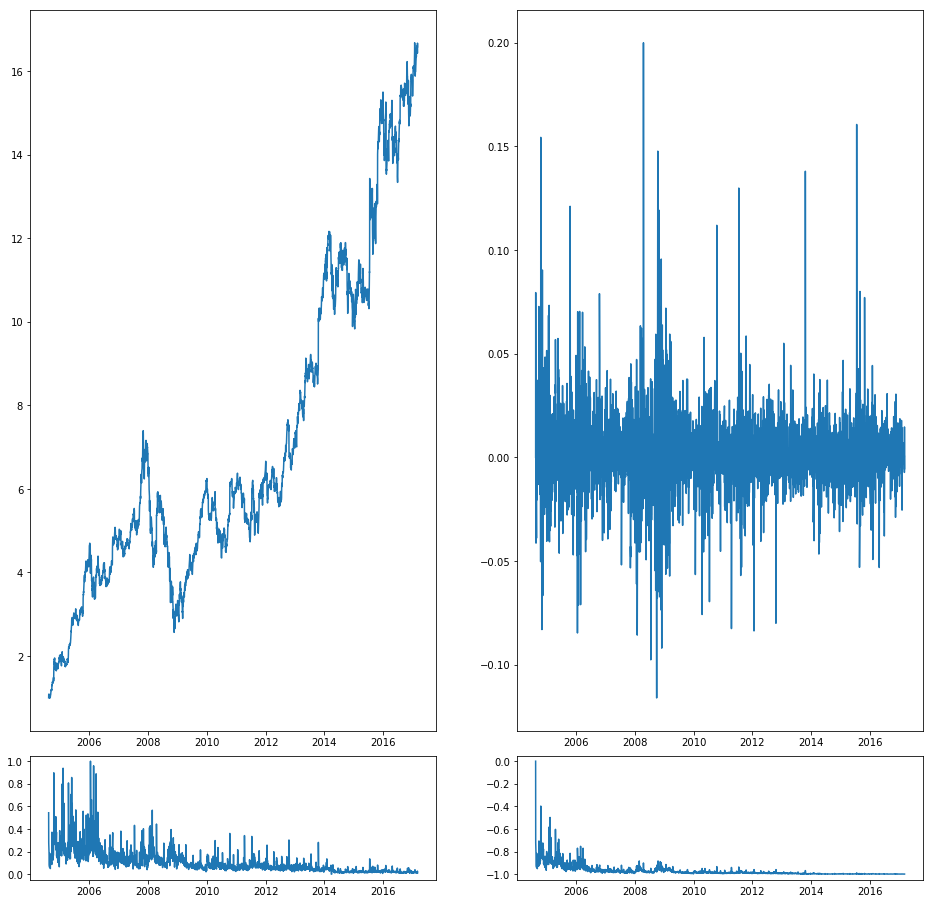

In [4]:
stock_data_preprocessing.stock_plot((data_n,))

# Pickup the Data

In [5]:
# training data
prediction_time = 1 #day

x_train = data_n[0:-prediction_time-100].as_matrix()
y_train = data_n[prediction_time:-100  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-100:-prediction_time].as_matrix()
y_test = data_n[prediction_time-100:  ]['Normalised Close'].as_matrix()



# unroll it

In [13]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

unroll_length=27
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2974, 27, 27, 27, 12)
y_train (2974,)
x_test (18, 27, 27, 27, 12)
y_test (18,)


# Go! (with Python 3.5, Keras 1.2.2 and Tensorflow 1.0, better on AWS)

In [8]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [9]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.05804800987243652


In [10]:
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model
    
model = build_model2([12,unroll_length,1])

In [11]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=1)



ValueError: Input arrays should have the same number of samples as target arrays. Found 3028 input samples and 3055 target samples.

In [ ]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=13,
    validation_split=0.05)

In [ ]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)